## Get acts

In [13]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from collections import defaultdict

In [14]:
model_name = 'llama-2-13B-GPTQ-4bit'

datasets = ['cities', 'neg_cities', 'sp_en_trans']
layers = list(range(8, 15))

# datasets = ['neg_sp_en_trans', 'larger_than', 'smaller_than', 'cities_cities_conj', 'cities_cities_disj', 'companies_true_false', 'common_claim_true_false']
# layers = 14

In [3]:
model_name_or_path = f'/storage/models/{model_name}'
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="cuda:0")
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [4]:
import os
import pickle
from tqdm import tqdm
for dataset in datasets:
    print(dataset)
    statements = pd.read_csv(f'/notebooks/got-replication/datasets/{dataset}.csv')['statement'].tolist()
    layer_to_acts = defaultdict(list)
    for statement in tqdm(statements):
        input_ids = tokenizer(statement, return_tensors='pt').input_ids.cuda()
        output = model(input_ids, output_hidden_states=True)
        for layer in layers:
            layer_acts = output['hidden_states'][layer+1][0][-1].to('cpu').detach().numpy() # first hidden is emb layer, so +1
            layer_to_acts[layer].append(layer_acts)
    
    dataset_path = f'/notebooks/got-replication/acts/{model_name}/{dataset}'
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    
    # save layer acts for this dataset
    for layer in layer_to_acts:
        with open(f'{dataset_path}/{layer}.pkl', 'wb') as f:
            pickle.dump(layer_to_acts[layer], f)

cities


100%|██████████| 1496/1496 [00:58<00:00, 25.71it/s]


neg_cities


100%|██████████| 1496/1496 [00:59<00:00, 25.25it/s]


sp_en_trans


100%|██████████| 354/354 [00:14<00:00, 25.18it/s]


## Plot PCA

In [15]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

In [16]:
def load_acts(datasets, layer):
    all_data = pd.DataFrame()
    for dataset in datasets:
        data = pd.read_csv(f'/notebooks/got-replication/datasets/{dataset}.csv')
        with open(f'/notebooks/got-replication/acts/{model_name}/{dataset}/{layer}.pkl', 'rb') as f:
            acts = pickle.load(f)
        # acts = np.array(acts)
        acts = acts - np.mean(acts, axis=0)
        data['acts'] = acts.tolist()
        data['dataset'] = dataset
        all_data = pd.concat([all_data, data])
        
    return all_data

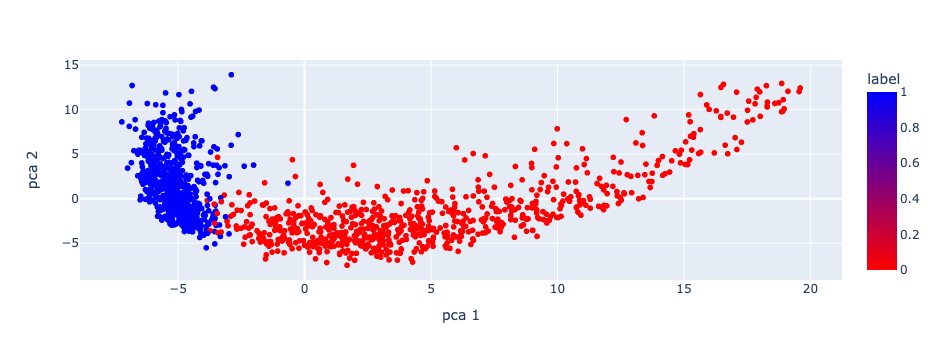

In [17]:
pca_datasets = ['cities']

data = load_acts(pca_datasets, 14)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.array(data['acts'].tolist()))
data[['pca 1', 'pca 2']] = X_pca
    
fig = px.scatter(data, x='pca 1', y='pca 2', color='label', color_continuous_scale='Bluered_r')
fig.show()

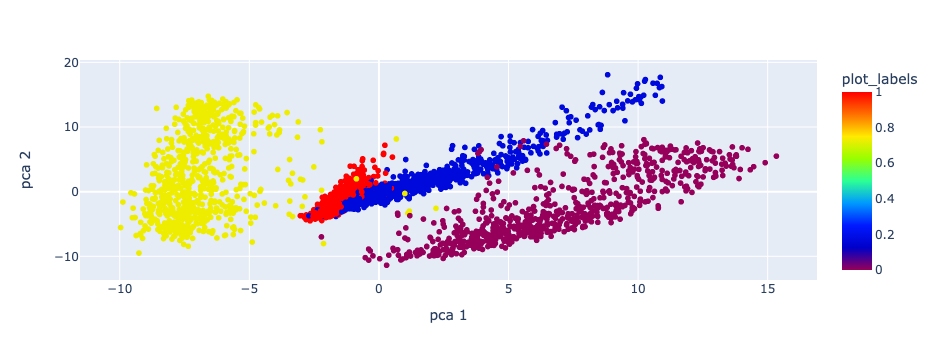

In [18]:
pca_datasets = ['cities', 'neg_cities']

data = load_acts(pca_datasets, 14)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.array(data['acts'].tolist()))
data[['pca 1', 'pca 2']] = X_pca

RED = 1
BLUE = .17
PURPLE = 0
YELLOW = .73

def color_labels(row):
    if row['dataset'] == pca_datasets[0]:
        return RED if row['label']==1 else BLUE
    elif row['dataset'] == pca_datasets[1]:
        return YELLOW if row['label']==1 else PURPLE
    
data['plot_labels'] = data.apply(lambda row: color_labels(row), axis=1)
    
fig = px.scatter(data, x='pca 1', y='pca 2', color='plot_labels')
fig.update_coloraxes(colorscale='Rainbow')
fig.show()

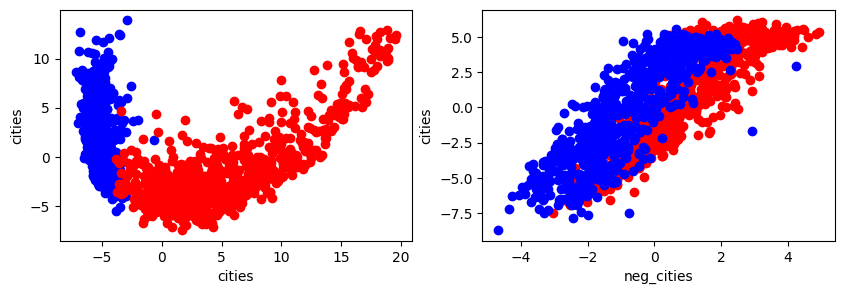

In [73]:
from plotly.subplots import make_subplots
pca_datasets = ['cities']
plot_datasets = ['cities', 'neg_cities']

pca_data = load_acts(pca_datasets, 14)
pca = PCA(n_components=2)
pca.fit(np.array(pca_data['acts'].tolist()))

fig, axes = plt.subplots(nrows=1, ncols=len(plot_datasets), figsize=(10,3))
for i, dataset in enumerate(plot_datasets):
    plot_data = load_acts([dataset], 14)
    X_pca = pca.transform(np.array(plot_data['acts'].tolist()))
    plot_data[['pca 1', 'pca 2']] = X_pca
    for label in plot_data['label'].unique():
        subset = plot_data[plot_data['label'] == label]
        axes[i].scatter(subset['pca 1'], subset['pca 2'], color='blue' if label==1 else 'red')
        axes[i].set_xlabel(dataset)
        axes[i].set_ylabel('/'.join(pca_datasets))
fig.show()

## Create probes

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LRProbe(nn.Module):
    
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(in_features=5120, out_features=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.linear(x))
    
    def direction(self):
        return self.
    


# Step 1: Prepare the dataset
# Let's create a simple dataset where y = 2x + 1
x_train = torch.tensor([[1.], [2.], [3.], [4.]], requires_grad=False)
y_train = torch.tensor([[3.], [5.], [7.], [9.]], requires_grad=False)

# Step 2: Define the model
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(in_features=1, out_features=1)  # One in and one out

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel()

# Step 3: Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Step 4: Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_train)

    # Compute and print loss
    loss = criterion(y_pred, y_train)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model (Inference)
with torch.no_grad():  # We don't need gradients in the testing phase
    predicted = model(torch.tensor([[5.]]))
    print(f'Predicted value for input 5: {predicted.item():.4f}')